In [ ]:
!pip install h5py scikit-learn matplotlib --quiet

import h5py
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.models as models
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader, Subset
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import os

###Define custom Dataset class (HDF5 + transforms)

In [ ]:
class GalaxyHDF5Dataset(Dataset):
    def __init__(self, h5_path, indices=None, transform=None):
        self.h5_path = h5_path
        self.indices = indices
        self.transform = transform

        # Open file once to get labels
        with h5py.File(self.h5_path, 'r') as f:
            self.labels = np.array(f['labels'])

    def __len__(self):
        return len(self.indices) if self.indices is not None else len(self.labels)

    def __getitem__(self, idx):
        real_idx = self.indices[idx] if self.indices is not None else idx
        with h5py.File(self.h5_path, 'r') as f:
            img = f['images'][real_idx]
            label = f['labels'][real_idx]

        img = Image.fromarray(img)  # Assuming already in 0–255 uint8
        if self.transform:
            img = self.transform(img)

        return img, label

### Define model and training functions

In [ ]:
def create_model(num_classes=10):
    model = models.resnet50(pretrained=True)
    model.fc = nn.Linear(model.fc.in_features, num_classes)
    return model

def train_one_epoch(model, dataloader, criterion, optimizer, device):
    model.train()
    total_loss, correct, total = 0, 0, 0
    for imgs, labels in dataloader:
        imgs, labels = imgs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(imgs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * labels.size(0)
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)
    return total_loss / total, correct / total

def validate(model, dataloader, criterion, device):
    model.eval()
    total_loss, correct, total = 0, 0, 0
    all_preds, all_labels = [], []
    with torch.no_grad():
        for imgs, labels in dataloader:
            imgs, labels = imgs.to(device), labels.to(device)
            outputs = model(imgs)
            loss = criterion(outputs, labels)
            total_loss += loss.item() * labels.size(0)
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    return total_loss / total, correct / total, all_preds, all_labels

### Stratified K-Fold Training Loop (k=5)


===== Fold 1/5 =====


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 94.1MB/s]


Epoch 1: Train Loss=0.8210, Acc=0.7126 | Val Loss=0.6154, Acc=0.7940
Epoch 2: Train Loss=0.4519, Acc=0.8491 | Val Loss=0.5403, Acc=0.8185
Epoch 3: Train Loss=0.2744, Acc=0.9081 | Val Loss=0.5575, Acc=0.8250
Epoch 4: Train Loss=0.1456, Acc=0.9523 | Val Loss=0.5758, Acc=0.8320
Epoch 5: Train Loss=0.0901, Acc=0.9723 | Val Loss=0.6681, Acc=0.8280
Epoch 6: Train Loss=0.0625, Acc=0.9814 | Val Loss=0.7034, Acc=0.8109
Epoch 7: Train Loss=0.0726, Acc=0.9780 | Val Loss=0.6267, Acc=0.8436
Epoch 8: Train Loss=0.0496, Acc=0.9842 | Val Loss=0.7265, Acc=0.8324
Epoch 9: Train Loss=0.0517, Acc=0.9831 | Val Loss=0.6763, Acc=0.8333
Epoch 10: Train Loss=0.0559, Acc=0.9817 | Val Loss=0.7021, Acc=0.8242
Saved model to /content/drive/MyDrive/galaxy_model_fold1.pt

Classification Report:
              precision    recall  f1-score   support

           0     0.6801    0.6068    0.6413       473
           1     0.8371    0.8671    0.8518       474
           2     0.9061    0.8161    0.8587       473
        

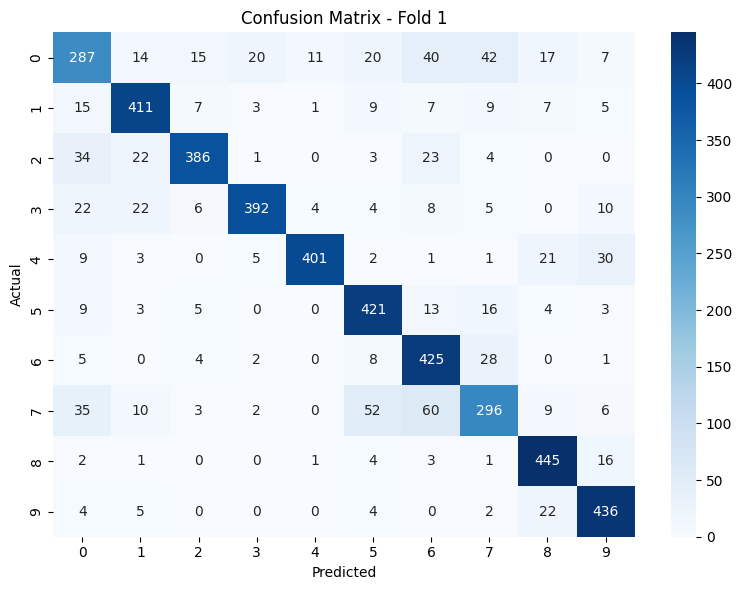

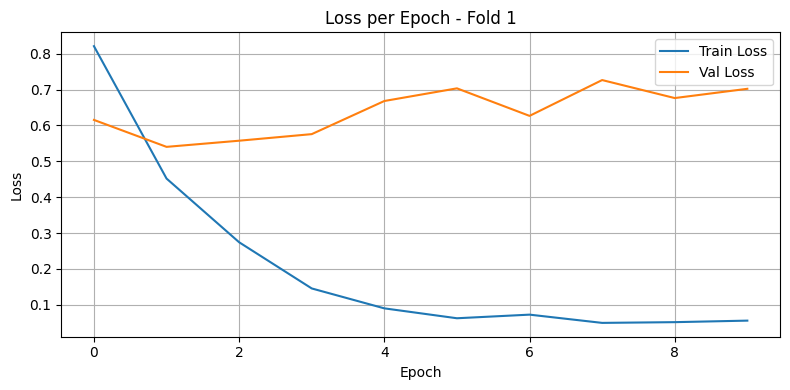

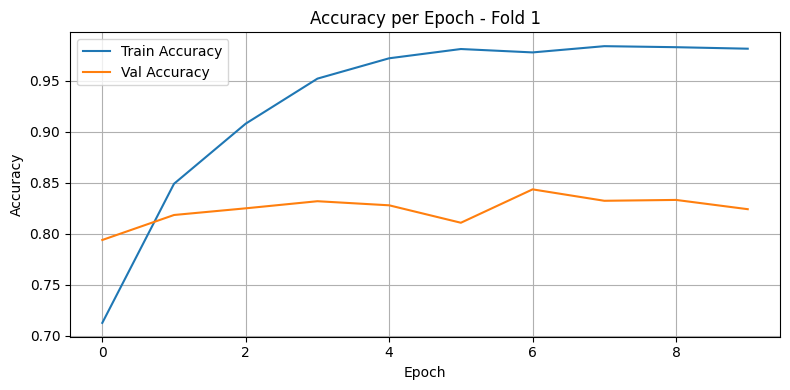


===== Fold 2/5 =====


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1: Train Loss=0.8212, Acc=0.7189 | Val Loss=0.5902, Acc=0.7942
Epoch 2: Train Loss=0.4586, Acc=0.8424 | Val Loss=0.5016, Acc=0.8339
Epoch 3: Train Loss=0.2804, Acc=0.9051 | Val Loss=0.4908, Acc=0.8404
Epoch 4: Train Loss=0.1554, Acc=0.9501 | Val Loss=0.5230, Acc=0.8457
Epoch 5: Train Loss=0.0893, Acc=0.9726 | Val Loss=0.6740, Acc=0.8231
Epoch 6: Train Loss=0.0759, Acc=0.9765 | Val Loss=0.5926, Acc=0.8445
Epoch 7: Train Loss=0.0505, Acc=0.9842 | Val Loss=0.6397, Acc=0.8375
Epoch 8: Train Loss=0.0486, Acc=0.9848 | Val Loss=0.7634, Acc=0.8195
Epoch 9: Train Loss=0.0684, Acc=0.9784 | Val Loss=0.6629, Acc=0.8360
Epoch 10: Train Loss=0.0444, Acc=0.9855 | Val Loss=0.6737, Acc=0.8428
Saved model to /content/drive/MyDrive/galaxy_model_fold2.pt

Classification Report:
              precision    recall  f1-score   support

           0     0.7850    0.6624    0.7185       474
           1     0.8365    0.9302    0.8809       473
           2     0.8571    0.9133    0.8843       473
        

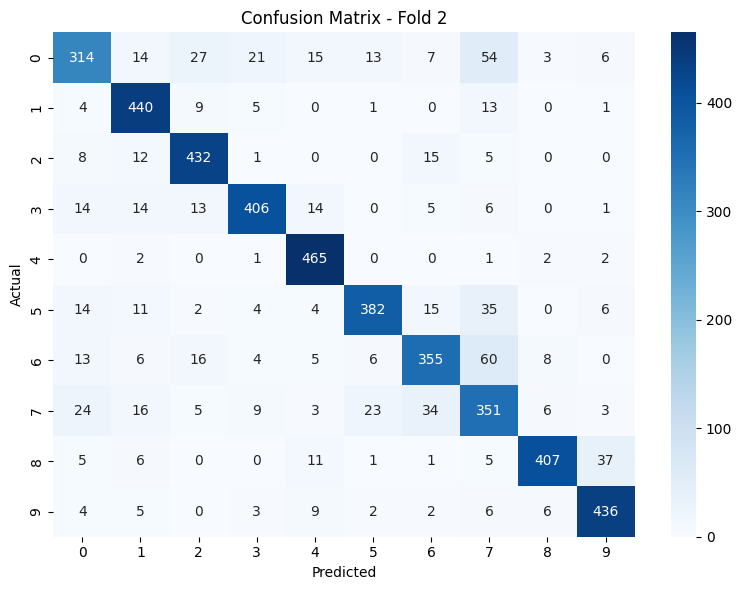

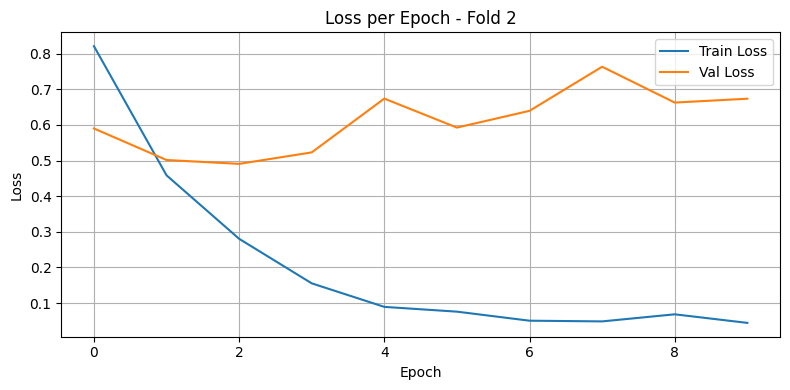

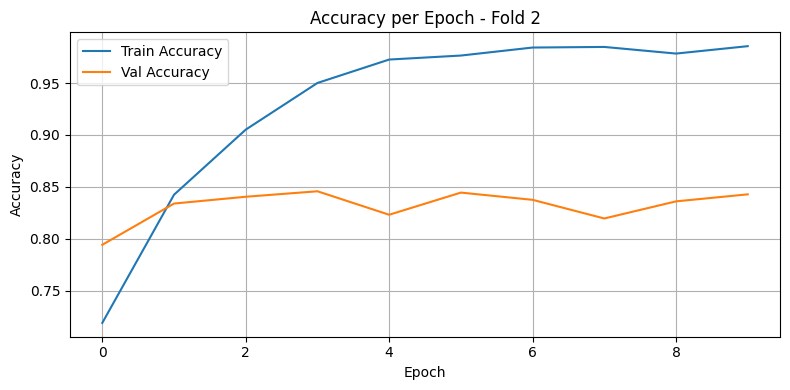


===== Fold 3/5 =====


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1: Train Loss=0.8165, Acc=0.7194 | Val Loss=0.5686, Acc=0.8045
Epoch 2: Train Loss=0.4520, Acc=0.8475 | Val Loss=0.5252, Acc=0.8261
Epoch 3: Train Loss=0.2641, Acc=0.9113 | Val Loss=0.5650, Acc=0.8155
Epoch 4: Train Loss=0.1504, Acc=0.9522 | Val Loss=0.5872, Acc=0.8318
Epoch 5: Train Loss=0.0892, Acc=0.9721 | Val Loss=0.6181, Acc=0.8366
Epoch 6: Train Loss=0.0671, Acc=0.9798 | Val Loss=0.6190, Acc=0.8369
Epoch 7: Train Loss=0.0600, Acc=0.9825 | Val Loss=0.6647, Acc=0.8341
Epoch 8: Train Loss=0.0626, Acc=0.9798 | Val Loss=0.7738, Acc=0.8136
Epoch 9: Train Loss=0.0476, Acc=0.9845 | Val Loss=0.7424, Acc=0.8324
Epoch 10: Train Loss=0.0579, Acc=0.9806 | Val Loss=0.7776, Acc=0.8250
Saved model to /content/drive/MyDrive/galaxy_model_fold3.pt

Classification Report:
              precision    recall  f1-score   support

           0     0.6604    0.6702    0.6653       473
           1     0.9083    0.8372    0.8713       473
           2     0.8629    0.9049    0.8834       473
        

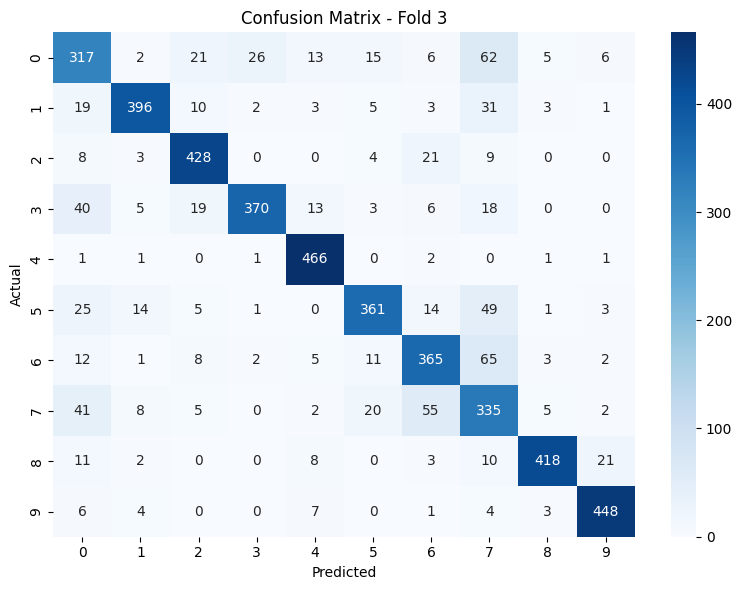

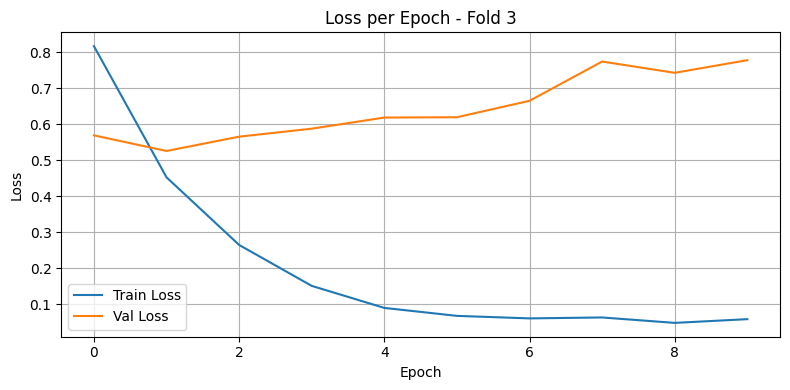

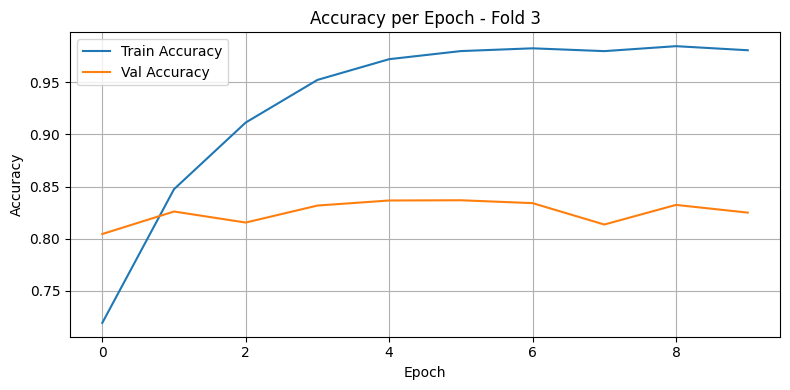


===== Fold 4/5 =====


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1: Train Loss=0.8104, Acc=0.7222 | Val Loss=0.6169, Acc=0.7899
Epoch 2: Train Loss=0.4555, Acc=0.8463 | Val Loss=0.5152, Acc=0.8305
Epoch 3: Train Loss=0.2688, Acc=0.9079 | Val Loss=0.5226, Acc=0.8288
Epoch 4: Train Loss=0.1477, Acc=0.9538 | Val Loss=0.5623, Acc=0.8356
Epoch 5: Train Loss=0.0863, Acc=0.9723 | Val Loss=0.6290, Acc=0.8206
Epoch 6: Train Loss=0.0753, Acc=0.9775 | Val Loss=0.7035, Acc=0.8204
Epoch 7: Train Loss=0.0576, Acc=0.9814 | Val Loss=0.6939, Acc=0.8335
Epoch 8: Train Loss=0.0462, Acc=0.9853 | Val Loss=0.7210, Acc=0.8318
Epoch 9: Train Loss=0.0573, Acc=0.9813 | Val Loss=0.8752, Acc=0.7967
Epoch 10: Train Loss=0.0523, Acc=0.9819 | Val Loss=0.6363, Acc=0.8443
Saved model to /content/drive/MyDrive/galaxy_model_fold4.pt

Classification Report:
              precision    recall  f1-score   support

           0     0.6895    0.6385    0.6630       473
           1     0.8530    0.8710    0.8619       473
           2     0.8693    0.8840    0.8766       474
        

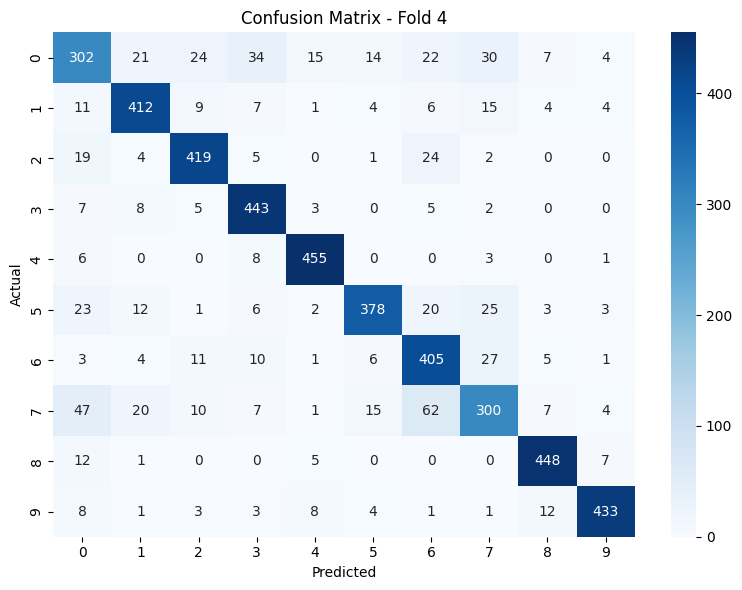

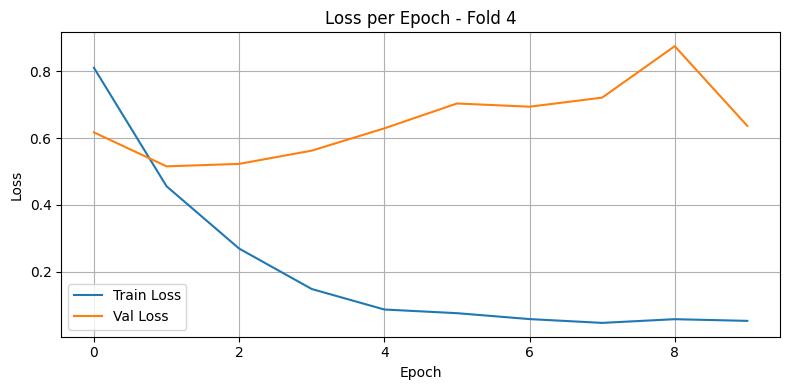

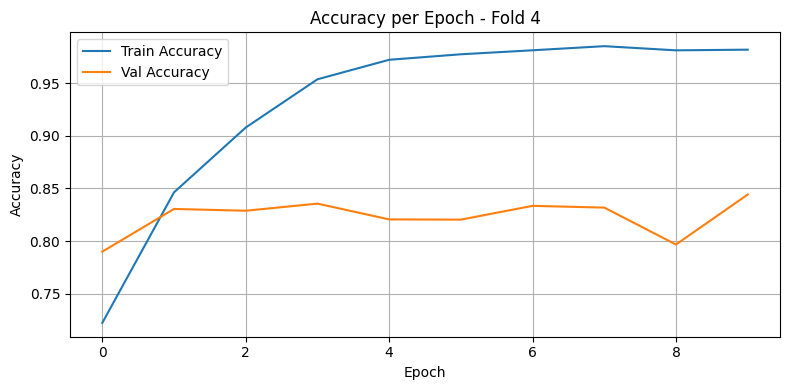


===== Fold 5/5 =====


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1: Train Loss=0.8223, Acc=0.7159 | Val Loss=0.5802, Acc=0.8045
Epoch 2: Train Loss=0.4628, Acc=0.8435 | Val Loss=0.5720, Acc=0.8011
Epoch 3: Train Loss=0.2664, Acc=0.9114 | Val Loss=0.6350, Acc=0.8020
Epoch 4: Train Loss=0.1518, Acc=0.9512 | Val Loss=0.5551, Acc=0.8316
Epoch 5: Train Loss=0.0857, Acc=0.9755 | Val Loss=0.6470, Acc=0.8242
Epoch 6: Train Loss=0.0666, Acc=0.9793 | Val Loss=0.6363, Acc=0.8388
Epoch 7: Train Loss=0.0664, Acc=0.9798 | Val Loss=0.6400, Acc=0.8402
Epoch 8: Train Loss=0.0530, Acc=0.9831 | Val Loss=0.7193, Acc=0.8276
Epoch 9: Train Loss=0.0514, Acc=0.9827 | Val Loss=0.9411, Acc=0.7948
Epoch 10: Train Loss=0.0626, Acc=0.9793 | Val Loss=0.7580, Acc=0.8259
Saved model to /content/drive/MyDrive/galaxy_model_fold5.pt

Classification Report:
              precision    recall  f1-score   support

           0     0.9127    0.4419    0.5954       473
           1     0.8191    0.8901    0.8531       473
           2     0.8634    0.8689    0.8662       473
        

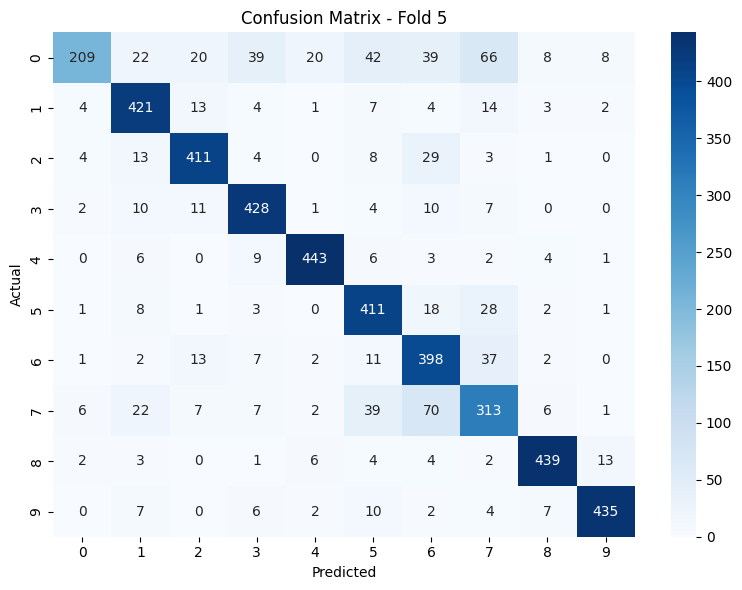

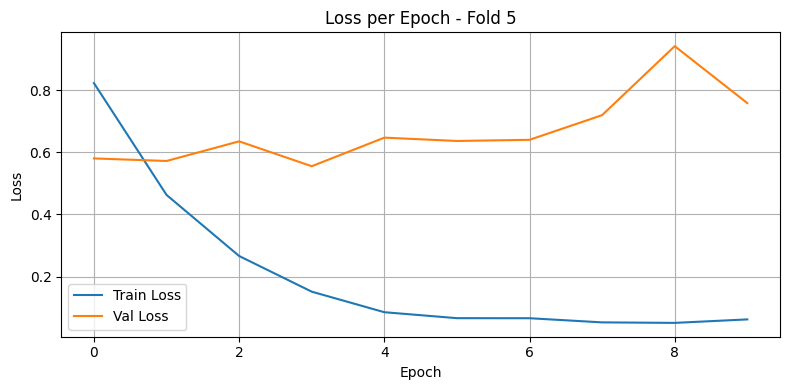

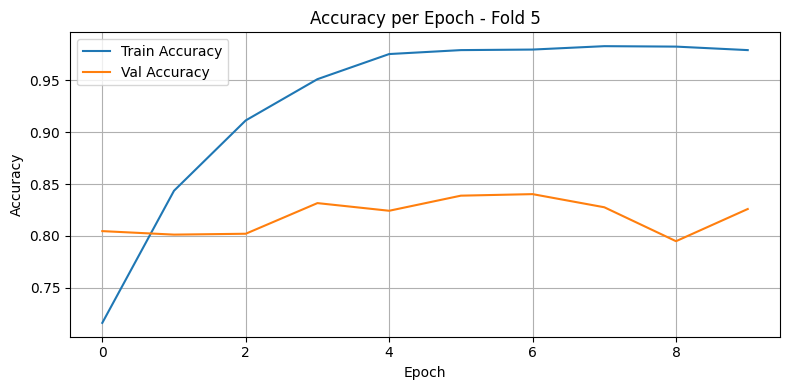

In [ ]:
from sklearn.model_selection import StratifiedKFold
from torchvision.transforms import ToTensor, Compose, Resize
from PIL import Image

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
h5_path = "/content/drive/MyDrive/Galaxy10_augmented.h5"
num_epochs = 10
batch_size = 32
k_folds = 5

# Get labels for splitting
with h5py.File(h5_path, 'r') as f:
    labels = np.array(f['labels'])

skf = StratifiedKFold(n_splits=k_folds, shuffle=True, random_state=42)

transform = Compose([
    Resize((224, 224)),
    ToTensor(),
])

for fold, (train_idx, val_idx) in enumerate(skf.split(np.zeros(len(labels)), labels)):
    print(f"\n===== Fold {fold + 1}/{k_folds} =====")

    train_dataset = GalaxyHDF5Dataset(h5_path, indices=train_idx, transform=transform)
    val_dataset = GalaxyHDF5Dataset(h5_path, indices=val_idx, transform=transform)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

    model = create_model(num_classes=10).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=1e-4)

    train_losses, val_losses = [], []
    train_accuracies, val_accuracies = [], []

    for epoch in range(num_epochs):
        train_loss, train_acc = train_one_epoch(model, train_loader, criterion, optimizer, device)
        val_loss, val_acc, _, _ = validate(model, val_loader, criterion, device)

        train_losses.append(train_loss)
        val_losses.append(val_loss)
        train_accuracies.append(train_acc)
        val_accuracies.append(val_acc)

        print(f"Epoch {epoch+1}: Train Loss={train_loss:.4f}, Acc={train_acc:.4f} | Val Loss={val_loss:.4f}, Acc={val_acc:.4f}")

    # Save model
    model_path = f"/content/drive/MyDrive/galaxy_model_fold{fold+1}.pt"
    torch.save(model.state_dict(), model_path)
    print(f"Saved model to {model_path}")

    # Get predictions on validation set
    _, _, val_preds, val_targets = validate(model, val_loader, criterion, device)

    # Classification report
    print("\nClassification Report:")
    print(classification_report(val_targets, val_preds, digits=4))

    # Confusion matrix
    cm = confusion_matrix(val_targets, val_preds)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f"Confusion Matrix - Fold {fold + 1}")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.tight_layout()
    plt.show()

    # Plot Loss
    plt.figure(figsize=(8, 4))
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Val Loss')
    plt.title(f"Loss per Epoch - Fold {fold + 1}")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # Plot Accuracy
    plt.figure(figsize=(8, 4))
    plt.plot(train_accuracies, label='Train Accuracy')
    plt.plot(val_accuracies, label='Val Accuracy')
    plt.title(f"Accuracy per Epoch - Fold {fold + 1}")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()